# QBUS6830 Tutorial Lab 11: Asymmetric GARCH Models and Forecasting

## Data
In this lab session we will use daily data on BHP returns, from Jan, 2000 to July, 2021. The data can be found in the files `bhp_yf_2000_2021.csv`.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from arch import univariate

In [4]:
# Download data automatically if file not present
name_bhp = 'bhp_yf_2000_2021.csv'

# BHP
if not os.path.isfile(name_bhp):
    data_bhp = yf.download("BHP.AX", start='2000-01-01', end='2021-07-20')
    data_bhp.to_csv(name_bhp)

In [5]:
data = pd.read_csv(name_bhp, index_col='Date', parse_dates=True, dayfirst=True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,8.317775,8.317775,8.317775,8.317775,3.761003,0
2000-01-04,8.317359,8.620943,8.317359,8.608466,3.892442,9525499
2000-01-05,8.404691,8.462913,8.300724,8.408018,3.801807,8727404
2000-01-06,8.425485,8.566880,8.425485,8.462913,3.826628,7274950
2000-01-07,8.487449,8.941161,8.483706,8.880860,4.015611,15832421
...,...,...,...,...,...,...
2021-07-13,51.459999,51.610001,50.700001,50.700001,47.642834,5725789
2021-07-14,51.000000,51.220001,50.730000,50.959999,47.887154,4033496
2021-07-15,50.970001,51.660000,50.779999,51.529999,48.422783,5757487


In [6]:
# It is actually not necessary to truncate the return
# series; we do it to speed up the forecasting later.
p = data['Adj Close']
r_all = 100 * np.log(p).diff().dropna()
r = r_all[:'2017-10-16']
r

Date
2000-01-04    3.435129
2000-01-05   -2.356032
2000-01-06    0.650759
2000-01-07    4.820532
2000-01-10    0.769651
                ...   
2017-10-10   -0.226164
2017-10-11    0.489366
2017-10-12   -1.589734
2017-10-13    0.570677
2017-10-16    2.213551
Name: Adj Close, Length: 4500, dtype: float64

### Q1 (Python and GARCH forecasting: fixed origin, moving horizon)

### (a) Using the first 4000 days as the in-sample period, fit the models GARCH-t, GJR-GARCH-t, EGARCH-N, EGARCH-t, all with constant means, the compare their estimated in-sample volatility series with that of the RiskMetrics model. 

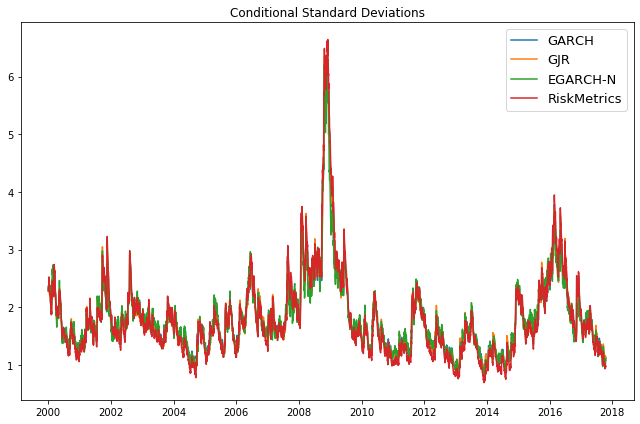

In [7]:
garch_t = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')
garch_t_fit = garch_t.fit( disp= 'off' )

gjr_t = arch_model(r, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
gjr_t_fit = gjr_t.fit( disp= 'off' )

egarch_n = arch_model(r, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='normal')
egarch_n_fit = egarch_n.fit( disp= 'off' )

egarch_t = arch_model(r, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='StudentsT')
egarch_t_fit = egarch_t.fit( disp= 'off' )

rm = arch_model(r, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal')
rm_fit = rm.fix(params = [0, 0.06, 0.94])

plt.figure(figsize=(9, 6))
plt.plot(garch_t_fit.conditional_volatility, label='GARCH')
plt.plot(gjr_t_fit.conditional_volatility, label='GJR')
plt.plot(egarch_n_fit.conditional_volatility, label='EGARCH-N')
plt.plot(rm_fit.conditional_volatility, label='RiskMetrics')
plt.title('Conditional Standard Deviations')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

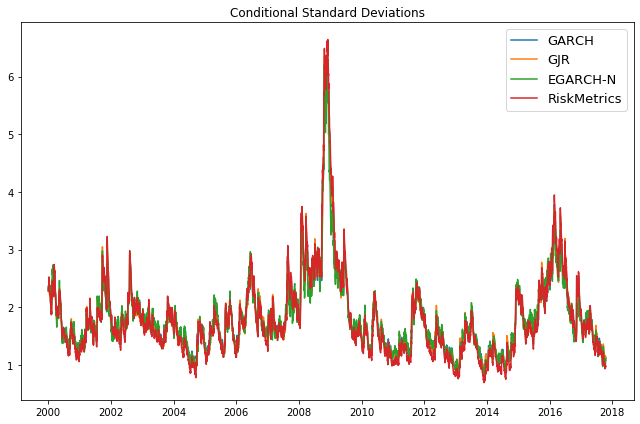

In [10]:
plt.figure(figsize=(9, 6))
plt.plot(garch_t_fit.conditional_volatility, label='GARCH')
plt.plot(gjr_t_fit.conditional_volatility, label='GJR')
plt.plot(egarch_n_fit.conditional_volatility, label='EGARCH-N')
plt.plot(rm_fit.conditional_volatility, label='RiskMetrics')
plt.title('Conditional Standard Deviations')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

#### (b) Using a forecast origin of day 4000, generate from 1 up to 950-step-ahead forecasts of volatility, for the next 950 daily returns, for the models: GARCH-t, GJR-GARCH-t, EGARCH-N, EGARCH-t, all with constant means, and RiskMetrics. Plot these volatility forecasts and comment/compare.

In [11]:
'''
Multi-step ahead forecasts. The 'forecast' method will be computationally very
expensive if we didn't truncate the return series earlier. When align='origin',
the t-th row of forecasts contains the forecasts for t+1, ..., t+h.
Analytical methods fore EGARCH multi-step ahead forecasts are not available;
we need to use simulations.
'''

h = len(r_all['2017-10-17':])

f_garch_t = garch_t_fit.forecast(
    horizon=h, align='origin', reindex=False).variance.values.T

f_gjr_t = gjr_t_fit.forecast(
    horizon=h, align='origin', reindex=False).variance.values.T

f_egarch_n = egarch_n_fit.forecast(
    horizon=h, method='simulation', simulations=10000,
    align='origin', reindex=False).variance.values.T

f_egarch_t = egarch_t_fit.forecast(
    horizon=h, method='simulation', simulations=10000,
    align='origin', reindex=False).variance.values.T

f_rm = rm_fit.forecast(horizon=h, align='origin', reindex=False).variance.values.T

In [12]:
h

950

In [13]:
# GARCH(1,1) unconditional (long-run) variance
a0 = garch_t_fit.params['omega']
a1 = garch_t_fit.params['alpha[1]']
b1 = garch_t_fit.params['beta[1]']
garch_t_uncvar = a0 / (1 - a1 - b1)

# GJR-GARCH(1,1) unconditional (long-run) variance
a0 = gjr_t_fit.params['omega']
a1 = gjr_t_fit.params['alpha[1]']
b1 = gjr_t_fit.params['beta[1]']
g1 = gjr_t_fit.params['gamma[1]']
gjr_t_uncvar = a0 / (1 - a1 - b1 - g1 / 2)

# Analytical forms for the EGARCH unconditional variance is not available.
# We can resort to sample approximations if we like, but they are inaccurate.

# EGARCH-Normal unconditional (long-run) variance
# egarch_uncvar = (egarch_fit.conditional_volatility ** 2).mean()

# EGARCH-t unconditional (long-run) variance
# egarch_t_uncvar = (egarch_t_fit.conditional_volatility ** 2).mean()

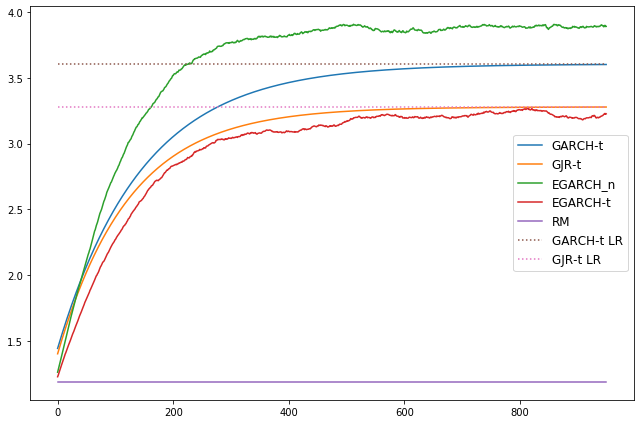

In [14]:
# Plot the forecasts
plt.figure(figsize=(9, 6))
plt.plot(f_garch_t, label='GARCH-t')
plt.plot(f_gjr_t, label='GJR-t')
plt.plot(f_egarch_n, label='EGARCH_n')
plt.plot(f_egarch_t, label='EGARCH-t')
plt.plot(f_rm, label='RM')
plt.plot(np.ones(h) * garch_t_uncvar, ':', label='GARCH-t LR')
plt.plot(np.ones(h) * gjr_t_uncvar, ':', label='GJR-t LR')
# plt.plot(np.ones(h) * ar1_egarch_uncvar, ':', label='EGARCH LR')
# plt.plot(np.ones(h) * ar1_egarch_t_uncvar, ':', label='EGARCH-t LR')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### (c) Assess the accuracy of each model's volatility forecasts using the 4 volatility proxies 1-4. Which models did best overall?

In [15]:
# Volatility proxies
rng = 100 * (np.log(data['High']) - np.log(data['Low']))[1:]
rng[rng <= 0] = np.mean([0, np.min(rng[rng > 0])])
ovn = 100 * (np.log(data['Open']) - np.log(data['Close']).shift(1)).dropna()

proxy1 = (r_all - r_all.mean()) ** 2
proxy2 = 0.3607 * rng ** 2
proxy3 = 1.107 * proxy2 + 0.68 * ovn ** 2
proxy4 = np.exp(2 * np.log(rng) - 0.86 + 2 * 0.29 ** 2)

f_proxy1 = proxy1['2017-10-17':]
f_proxy2 = proxy2['2017-10-17':]
f_proxy3 = proxy3['2017-10-17':]
f_proxy4 = proxy4['2017-10-17':]

In [16]:
# Loss tables
f_model = np.hstack([f_garch_t, f_gjr_t, f_egarch_n, f_egarch_t, f_rm])
f_proxy = np.vstack([f_proxy1, f_proxy2, f_proxy3, f_proxy4]).T

f_model = np.sqrt(f_model)
f_proxy = np.sqrt(f_proxy)

n_model = f_model.shape[1]
n_proxy = f_proxy.shape[1]

f_model_rep = f_model.repeat(n_proxy, axis=1)
f_proxy_rep = np.tile(f_proxy, [1, n_model])

rmse = np.sqrt(np.mean((f_model_rep - f_proxy_rep) ** 2, axis=0))
rmse = rmse.reshape(n_model, -1)

mad = np.mean(np.absolute(f_model_rep - f_proxy_rep), axis=0)
mad = mad.reshape(n_model, -1)

In [17]:
mdl_name = ['GARCH-t', 'GJR-t', 'EG-n', 'EG-t', 'RM']
prx_name = ['Proxy 1', 'Proxy 2', 'Proxy 3', 'Proxy 4']
tbl_rmse = pd.DataFrame(rmse, index=mdl_name, columns=prx_name)
tbl_rmse.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
GARCH-t,1.3285,1.0856,0.9781,1.0250
GJR-t,1.3040,1.0314,0.9493,0.9787
EG-n,1.3672,1.1584,1.0232,1.0897
EG-t,1.2945,1.0102,0.9388,0.9604
RM,1.2351,0.6372,0.9068,0.7152


In [18]:
tbl_mad = pd.DataFrame(mad, index=mdl_name, columns=prx_name)
tbl_mad.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
GARCH-t,1.0253,1.0020,0.7642,0.8944
GJR-t,0.9930,0.9430,0.7241,0.8404
EG-n,1.0730,1.0791,0.8218,0.9669
EG-t,0.9801,0.9185,0.7085,0.8176
RM,0.7999,0.4403,0.5176,0.4249


#### (d) Plot the volatility forecasts together with each proxy, separately. Explain why the results in part (c) occurred.

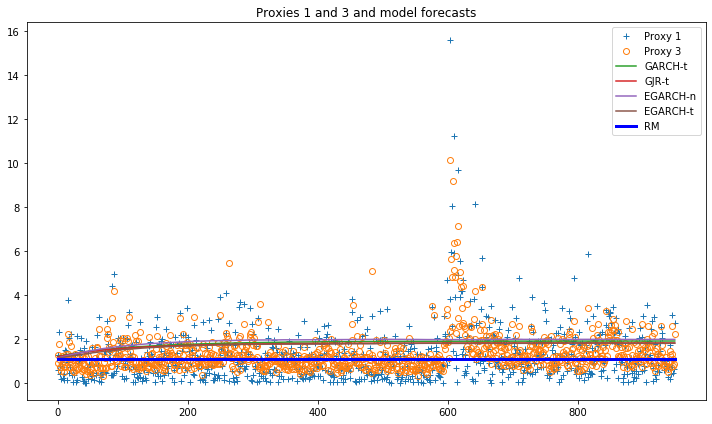

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(f_proxy1.values), '+', label='Proxy 1')
plt.plot(np.sqrt(f_proxy3.values), 'o', mfc='none', label='Proxy 3')
plt.plot(np.sqrt(f_garch_t), label='GARCH-t')
plt.plot(np.sqrt(f_gjr_t), label='GJR-t')
plt.plot(np.sqrt(f_egarch_n), label='EGARCH-n')
plt.plot(np.sqrt(f_egarch_t), label='EGARCH-t')
plt.plot(np.sqrt(f_rm), label='RM', color='blue', linewidth=3)
plt.title('Proxies 1 and 3 and model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

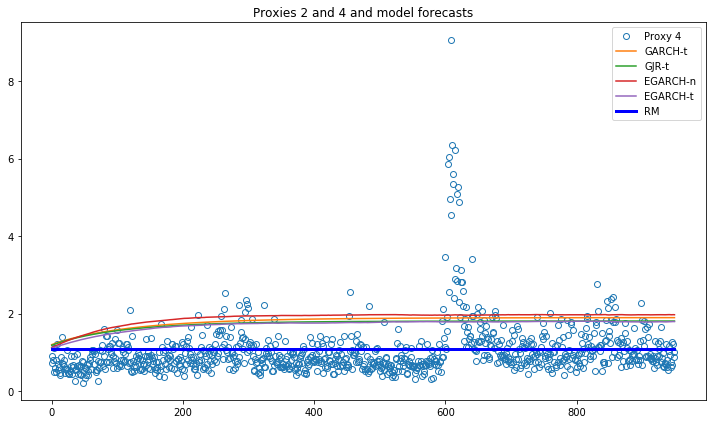

In [29]:
plt.figure(figsize=(10, 6))
# plt.plot(np.sqrt(f_proxy2.values), '+', label='Proxy 2')
plt.plot(np.sqrt(f_proxy4.values), 'o', mfc='none', label='Proxy 4')
plt.plot(np.sqrt(f_garch_t), label='GARCH-t')
plt.plot(np.sqrt(f_gjr_t), label='GJR-t')
plt.plot(np.sqrt(f_egarch_n), label='EGARCH-n')
plt.plot(np.sqrt(f_egarch_t), label='EGARCH-t')
plt.plot(np.sqrt(f_rm), label='RM', color='blue', linewidth=3)
plt.title('Proxies 2 and 4 and model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

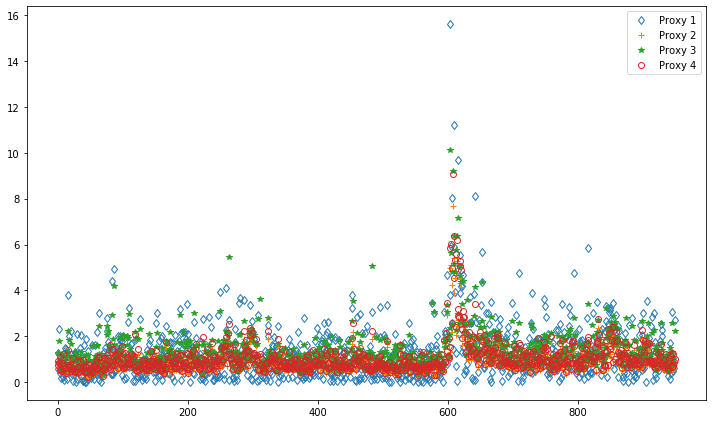

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(f_proxy1.values), 'd', mfc='none', label='Proxy 1')
plt.plot(np.sqrt(f_proxy2.values), '+', label='Proxy 2')
plt.plot(np.sqrt(f_proxy3.values), '*', label='Proxy 3')
plt.plot(np.sqrt(f_proxy4.values), 'o', mfc='none', label='Proxy 4')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Q2 (Python and GARCH forecasting: moving origin, fixed horizon)

(a) After day 4000, generate 1 step-ahead forecasts of volatility for the models from Q1, plus ARCH(13)-N, ARCH(13)-t, GARCH-N, GJR-GARCH-N, updating the forecast origin for each forecast, until the end of the forecast sample. Update (i.e. re-estimate) the parameter estimates once every 25 trading days. Plot these and comment on apparent forecast accuracy.

In [16]:
n_fore = len(r_all) - len(r)
farch13 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
farch13_t = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fgarch = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fgarch_t = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fgjr = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fgjr_t = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fegarch = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fegarch_t = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
frm = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_T = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_100 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')
fs2_25 = pd.Series(index=r_all[-n_fore:].index, dtype='float64')

# Re-instanciate the model objects with full data
arch13_all = arch_model(r_all, mean='Constant', vol='ARCH', p=13, dist='Normal')
garch_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')
gjr_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='Normal')
egarch_all = arch_model(r_all, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal')
arch13_t_all = arch_model(r_all, mean='Constant', vol='ARCH', p=13, dist='StudentsT')
garch_t_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')
gjr_t_all = arch_model(r_all, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
egarch_t_all = arch_model(r_all, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='StudentsT')
rm_all = arch_model(r_all, mean='Zero', vol='GARCH', p=1, q=1, dist='Normal')

n_wind = len(r)
for i in tqdm(range(n_fore)):
    if i % 25 == 0:
        arch13_all_fit = arch13_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        garch_all_fit = garch_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        gjr_all_fit = gjr_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_all_fit = egarch_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        arch13_t_all_fit = arch13_t_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        garch_t_all_fit = garch_t_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        gjr_t_all_fit = gjr_t_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_t_all_fit = egarch_t_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        rm_all_fit = rm_all.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        
    temp = arch13_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    farch13[i] = temp.loc[farch13.index[i]]
    
    temp = garch_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    fgarch[i] = temp.loc[fgarch.index[i]]
    
    temp = gjr_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    fgjr[i] = temp.loc[fgjr.index[i]]
    
    temp = egarch_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    fegarch[i] = temp.loc[fegarch.index[i]]
    
    temp = arch13_t_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    farch13_t[i] = temp.loc[farch13_t.index[i]]
    
    temp = garch_t_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    fgarch_t[i] = temp.loc[fgarch_t.index[i]]
    
    temp = gjr_t_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    fgjr_t[i] = temp.loc[fgjr_t.index[i]]
    
    temp = egarch_t_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    fegarch_t[i] = temp.loc[fegarch_t.index[i]]
    
    temp = rm_all_fit.forecast(horizon=1, align='target', reindex=False).variance
    frm[i] = temp.loc[frm.index[i]]
    
    # Ad-hoc methods
    fs2_T[i] = r_all[:(i + n_wind)].var()
    fs2_100[i] = r_all[(i + n_wind - 100):(i + n_wind)].var()
    fs2_25[i] = r_all[(i + n_wind - 25):(i + n_wind)].var()

  0%|          | 0/950 [00:00<?, ?it/s]

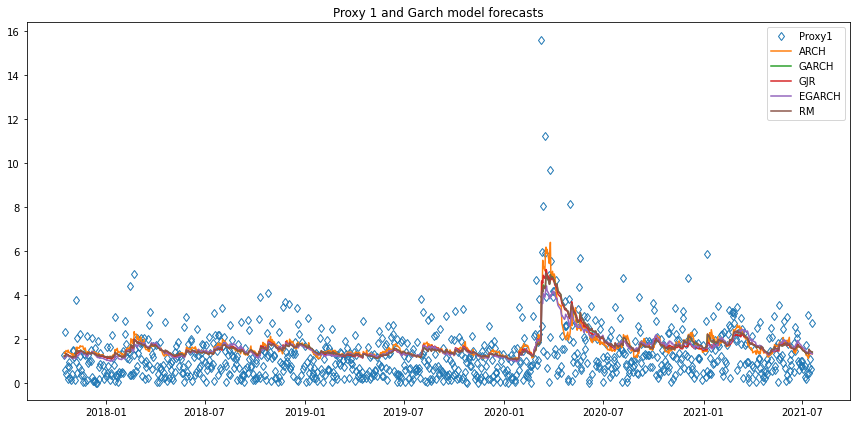

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy1), 'd', mfc='none', label='Proxy1')
plt.plot(np.sqrt(farch13), label='ARCH')
plt.plot(np.sqrt(fgarch), label='GARCH')
plt.plot(np.sqrt(fgjr), label='GJR')
plt.plot(np.sqrt(fegarch), label='EGARCH')
plt.plot(np.sqrt(frm), label='RM')
plt.title('Proxy 1 and Garch model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

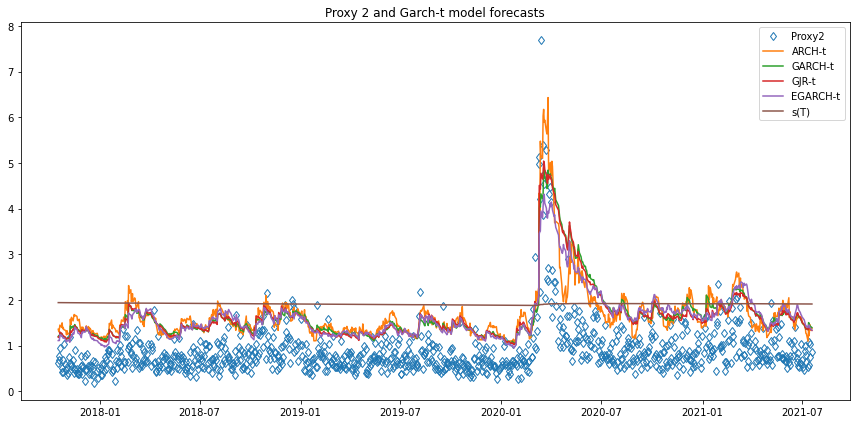

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy2), 'd', mfc='none', label='Proxy2')
plt.plot(np.sqrt(farch13_t), label='ARCH-t')
plt.plot(np.sqrt(fgarch_t), label='GARCH-t')
plt.plot(np.sqrt(fgjr_t), label='GJR-t')
plt.plot(np.sqrt(fegarch_t), label='EGARCH-t')
plt.plot(np.sqrt(fs2_T), label='s(T)')
plt.title('Proxy 2 and Garch-t model forecasts')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

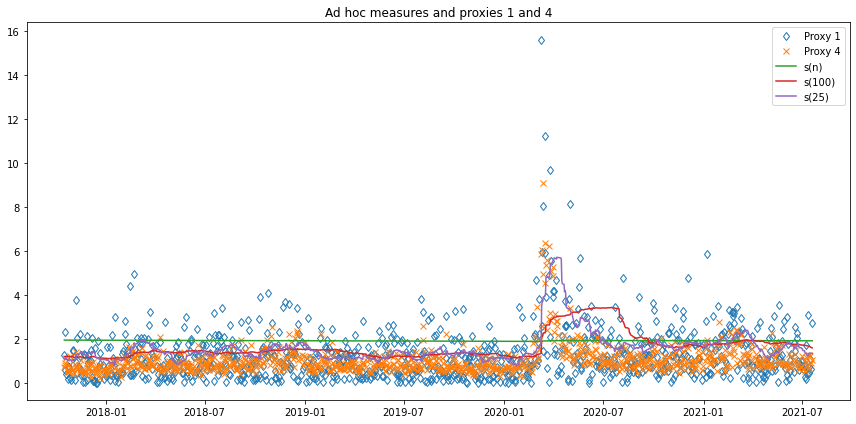

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(np.sqrt(f_proxy1), 'd', mfc='none', label='Proxy 1')
plt.plot(np.sqrt(f_proxy4), 'x', mfc='none', label='Proxy 4')
plt.plot(np.sqrt(fs2_T), label='s(n)')
plt.plot(np.sqrt(fs2_100), label='s(100)')
plt.plot(np.sqrt(fs2_25), label='s(25)')
plt.title('Ad hoc measures and proxies 1 and 4')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

#### (b) Assess the accuracy of each model's volatility forecasts using the 4 volatility proxies 1-4. Which models did best overall?

In [20]:
f_model = np.vstack([farch13, fgarch, fgjr, fegarch, frm, fs2_T, fs2_100, fs2_25, farch13_t, fgarch_t, fgjr_t, fegarch_t]).T
f_proxy = np.vstack([f_proxy1, f_proxy2, f_proxy3, f_proxy4]).T

f_model = np.sqrt(f_model)
f_proxy = np.sqrt(f_proxy)

n_model = f_model.shape[1]
n_proxy = f_proxy.shape[1]

f_model_rep = f_model.repeat(n_proxy, axis=1)
f_proxy_rep = np.tile(f_proxy, [1, n_model])

rmse = np.sqrt(np.mean((f_model_rep - f_proxy_rep) ** 2, axis=0))
rmse = rmse.reshape(n_model, -1)

mad = np.mean(np.absolute(f_model_rep - f_proxy_rep), axis=0)
mad = mad.reshape(n_model, -1)

In [21]:
mdl_name = ['ARCH', 'GARCH', 'GJR', 'EGARCH', 'RM', 's(T)', 's(100)', 's(25)', 'ARCH-t', 'GARCH-t', 'GJR-t', 'EGARCH-t']
prx_name = ['Proxy 1', 'Proxy 2', 'Proxy 3', 'Proxy 4']
tbl_rmse = pd.DataFrame(rmse, index=mdl_name, columns=prx_name)
tbl_rmse.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
ARCH,1.2264,0.9116,0.7802,0.8065
GARCH,1.2258,0.9023,0.7880,0.8071
GJR,1.2128,0.8842,0.7704,0.7867
EGARCH,1.2013,0.8612,0.7664,0.7761
RM,1.2275,0.9054,0.7909,0.8105
s(T),1.3834,1.1844,1.0414,1.1167
s(100),1.2989,1.0182,0.9444,0.9599
s(25),1.2639,0.9298,0.8397,0.8431
ARCH-t,1.2252,0.9135,0.7817,0.8094
GARCH-t,1.2293,0.9115,0.7967,0.8176


In [22]:
tbl_mad = pd.DataFrame(mad, index=mdl_name, columns=prx_name)
tbl_mad.round(4)

,Proxy 1,Proxy 2,Proxy 3,Proxy 4
ARCH,0.9191,0.8087,0.5887,0.6895
GARCH,0.9087,0.7913,0.5832,0.6801
GJR,0.9006,0.7754,0.5706,0.6653
EGARCH,0.8919,0.7689,0.5696,0.6623
RM,0.9102,0.7944,0.5857,0.6833
s(T),1.0936,1.1089,0.8444,0.9982
s(100),0.9495,0.8376,0.6620,0.7396
s(25),0.9074,0.7538,0.5803,0.6500
ARCH-t,0.9176,0.8095,0.5889,0.6904
GARCH-t,0.9106,0.7952,0.5880,0.6853


### (c) Do the forecast accuracy results match up with the forecast behavior shown in the plots? 

### (d) Discuss the performance of each model and attempt to explain why each model performed the way it did at 1 step ahead forecasting.